In [30]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

notification_df = pd.read_csv('../../data/notification_sequence.csv', sep = ',')
notification_df = pd.DataFrame(notification_df)

# drop '?'
notification_df = notification_df.replace('?', pd.NaT)
notification_df = notification_df.dropna(axis=0)

In [31]:
# label encoding
X_categorical_col = ['gender', 'department', 'scenario']
y_categorical_col = ['tol_111111', 'tol_1122', 'tol_123', 'tol_222', 'tol_24', 'tol_15']

X = notification_df.iloc[:, :-6]
y = notification_df.iloc[:, -6:]

labelencoder = LabelEncoder()
for i in X_categorical_col:
    X[i] = labelencoder.fit_transform(X[i])

le_name_mapping = []
for i in y_categorical_col:
    labelencoder.fit(y[i])
    le_name_mapping.append(dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_))))

# handle X with categorical in 'one-hot encode'
X = pd.get_dummies(X, columns = X_categorical_col)

In [32]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

def plot_confusion_matrix(confusion_mat, class_names):
    fig, ax = plt.subplots(figsize=(50, 50))
    ax.matshow(confusion_mat, cmap=plt.cm.Greens, alpha=0.3)
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(x=j, y=i, s=format(confusion_mat[i,j], '.4f'), va='center', ha='center', fontsize=50)
    plt.xticks(np.arange(len(class_names)), class_names, fontsize=50)
    plt.yticks(np.arange(len(class_names)), class_names, fontsize=50)
    plt.xlabel('Prediction', fontsize=80)
    plt.ylabel('Target', fontsize=80)
    plt.title('Confusion Matrix\n')

def holdout_func(X, y, mod):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
        
    print("Classification accuracy:", metrics.accuracy_score(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred))

    confusion_mat = metrics.confusion_matrix(y_test, y_pred, labels=class_names)
    plot_confusion_matrix(confusion_mat, class_names)


def KFold_func(X, y, num_split, mod):
    kf = KFold(n_splits=num_split, shuffle=False)

    y_pred_sum = 0
    confusion_mat_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        y_pred_sum += metrics.accuracy_score(y_test, y_pred)
        confusion_mat_list.append(metrics.confusion_matrix(y_test, y_pred, labels=class_names))
        
    print("Classification accuracy:", y_pred_sum / kf.get_n_splits(kf))
    print(metrics.classification_report(y_test, y_pred))

    mean_confusion_mat = np.mean(confusion_mat_list, axis=0)
    plot_confusion_matrix(mean_confusion_mat, class_names)

In [33]:
#X = preprocessing.normalize(X)

# Shuffle the data 10 times
for i in range(10):
    X, y = shuffle(X, y)

In [34]:
# random forest
from sklearn.ensemble import RandomForestClassifier

def random_forest_hold(k):
    print("Random Forest by holdout with k =", k, ":")
    rand_forest = RandomForestClassifier(n_estimators=k, max_depth=5, min_samples_leaf=8)

    holdout_func(X, y.iloc[:, 5], rand_forest)
    plt.show()

class_names = list(le_name_mapping[5].keys())

Random Forest by holdout with k = 10 :
Classification accuracy: 0.5661157024793388
              precision    recall  f1-score   support

      censwy       0.58      0.89      0.70       131
      ecnswy       0.00      0.00      0.00         5
      nceswy       0.50      0.30      0.38        63
      scenwy       0.33      0.03      0.06        31
      wcensy       0.00      0.00      0.00        11
      ycensw       0.00      0.00      0.00         1

    accuracy                           0.57       242
   macro avg       0.24      0.20      0.19       242
weighted avg       0.49      0.57      0.49       242



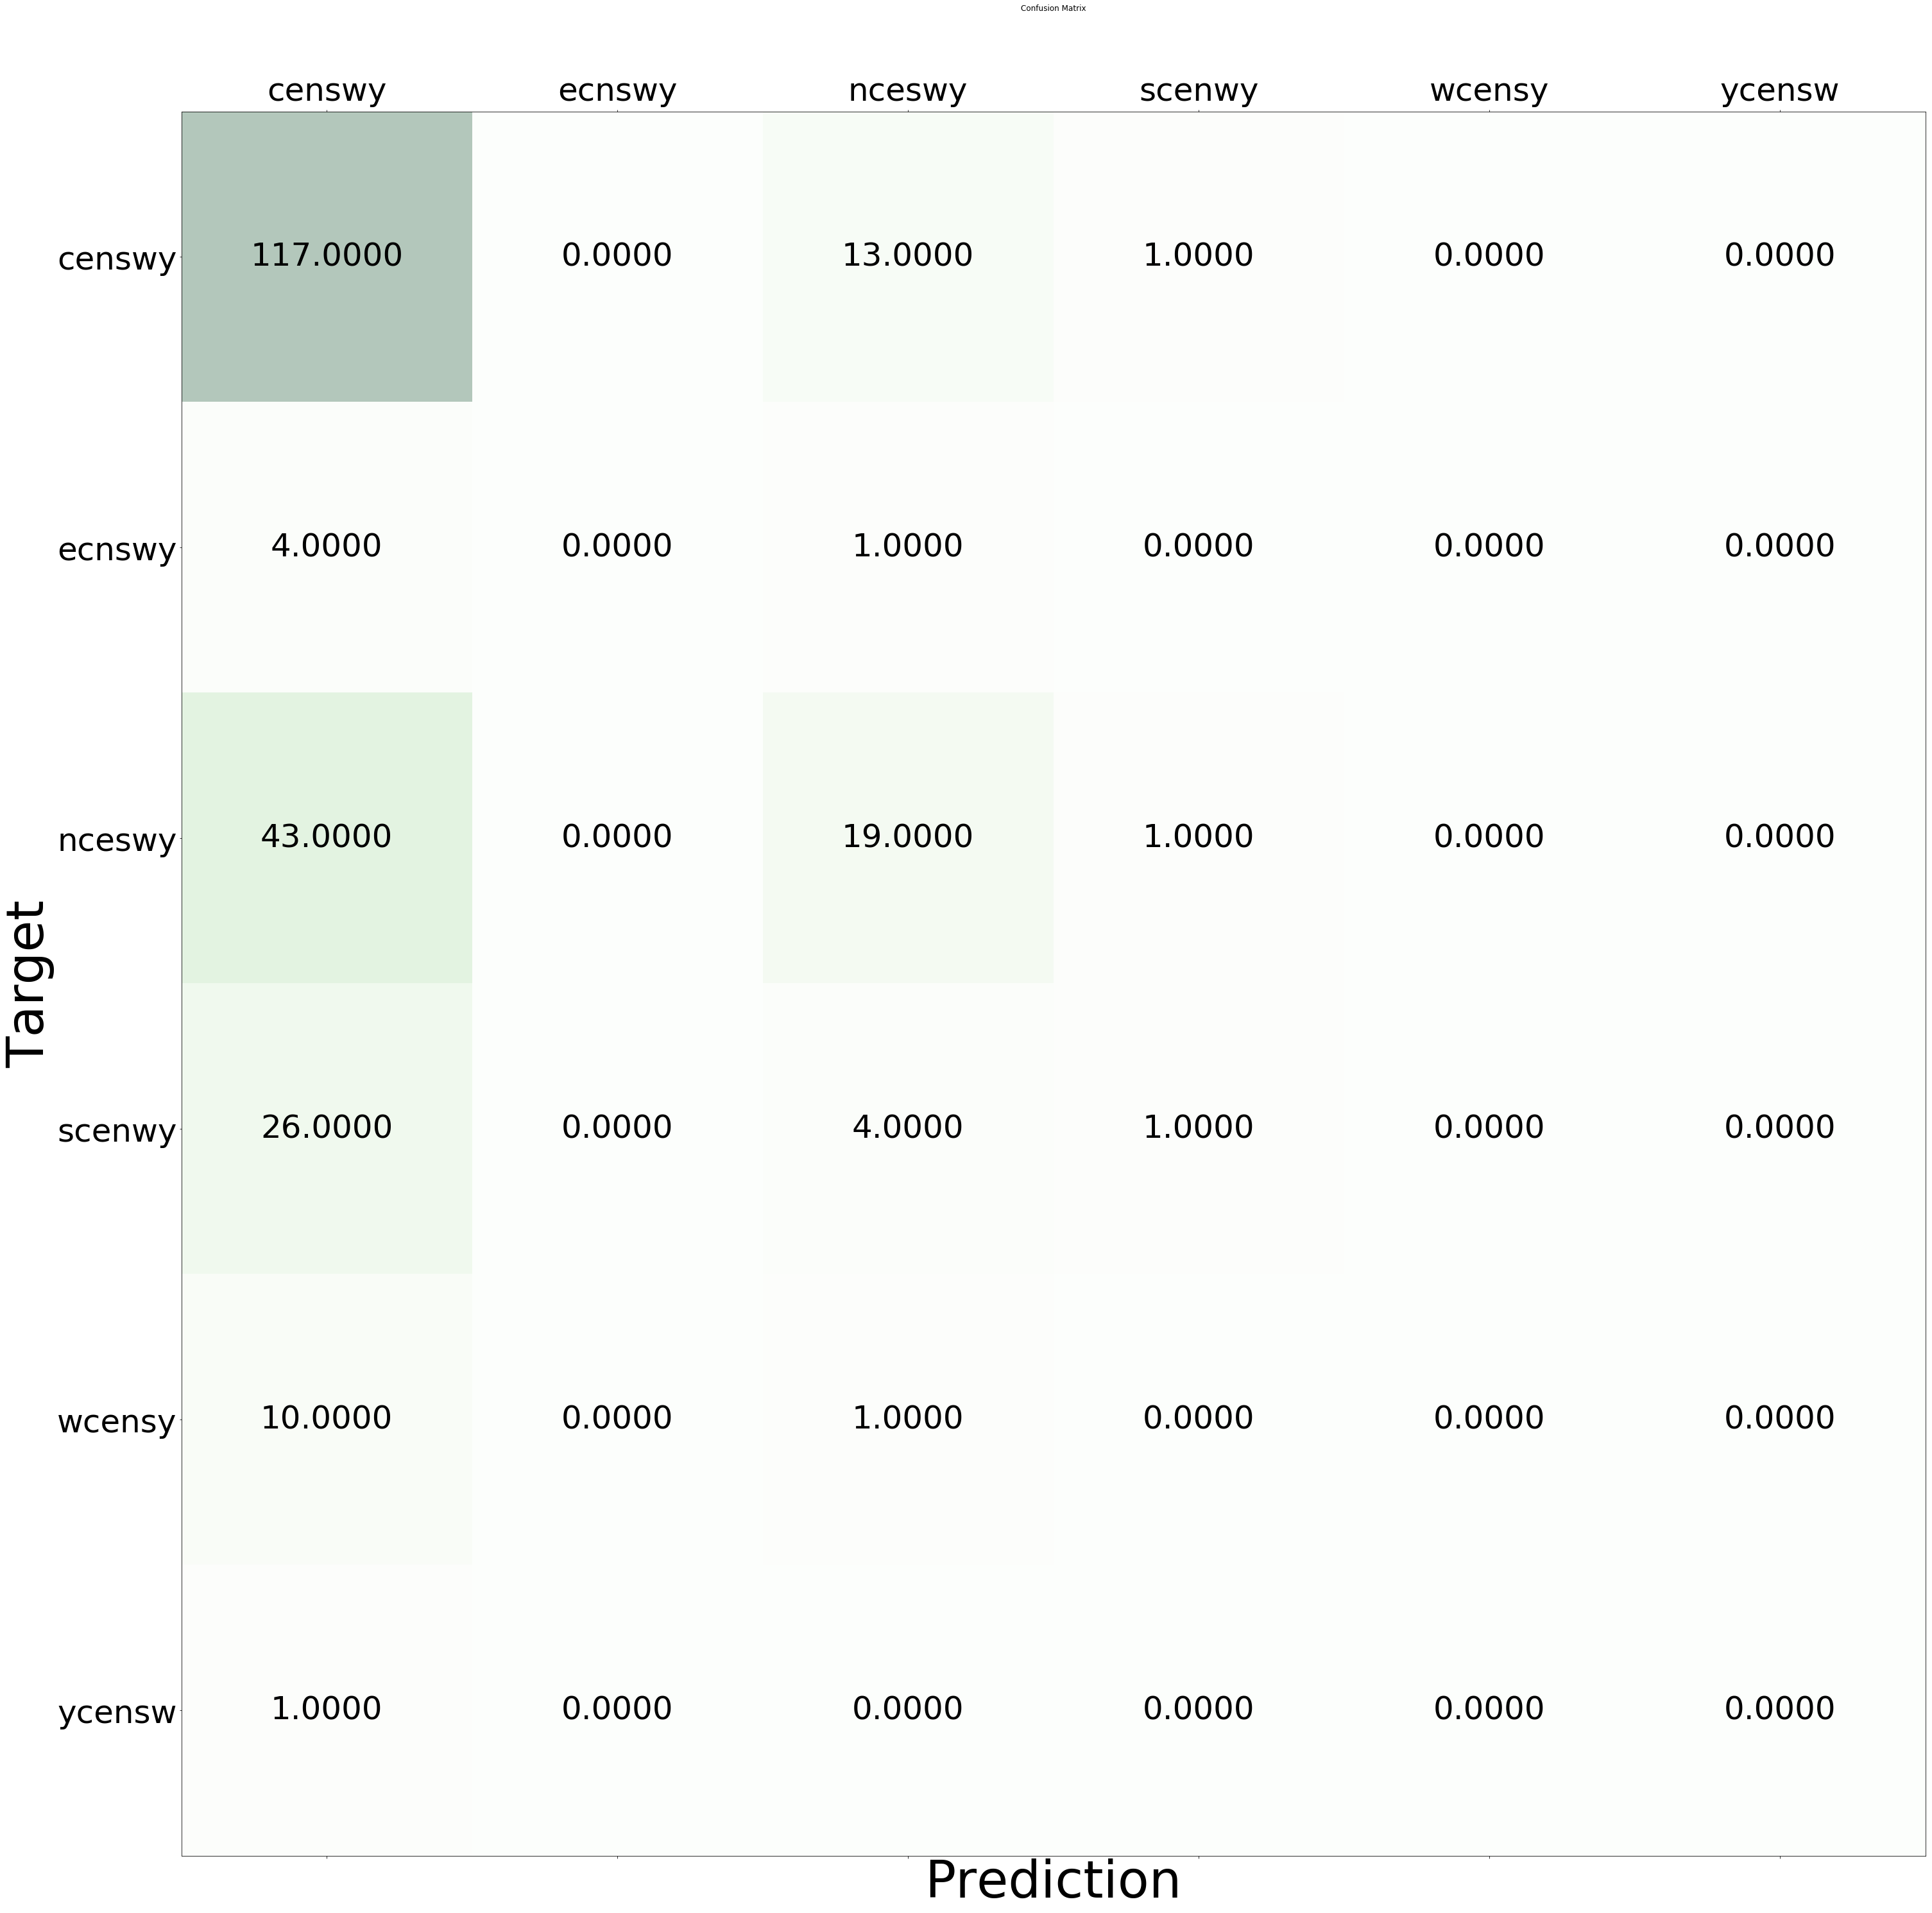

In [35]:
random_forest_hold(10)

In [36]:
def random_forest_KFold(k):
    print("Random Forest by KFold with k =", k)
    rand_forest = RandomForestClassifier(n_estimators=k, max_depth=5, min_samples_leaf=8)

    KFold_func(X, y, 5, rand_forest)
    plt.show()
    
X = np.array(X)
y = np.array(y.iloc[:, 5].tolist())

Random Forest by KFold with k = 10
Classification accuracy: 0.5075000000000001
              precision    recall  f1-score   support

      censwy       0.54      0.83      0.66        83
      ecnswy       0.00      0.00      0.00         5
      nceswy       0.52      0.39      0.44        44
      scenwy       0.00      0.00      0.00        20
      wcensy       0.00      0.00      0.00         7
      ycensw       0.00      0.00      0.00         1

    accuracy                           0.54       160
   macro avg       0.18      0.20      0.18       160
weighted avg       0.42      0.54      0.46       160



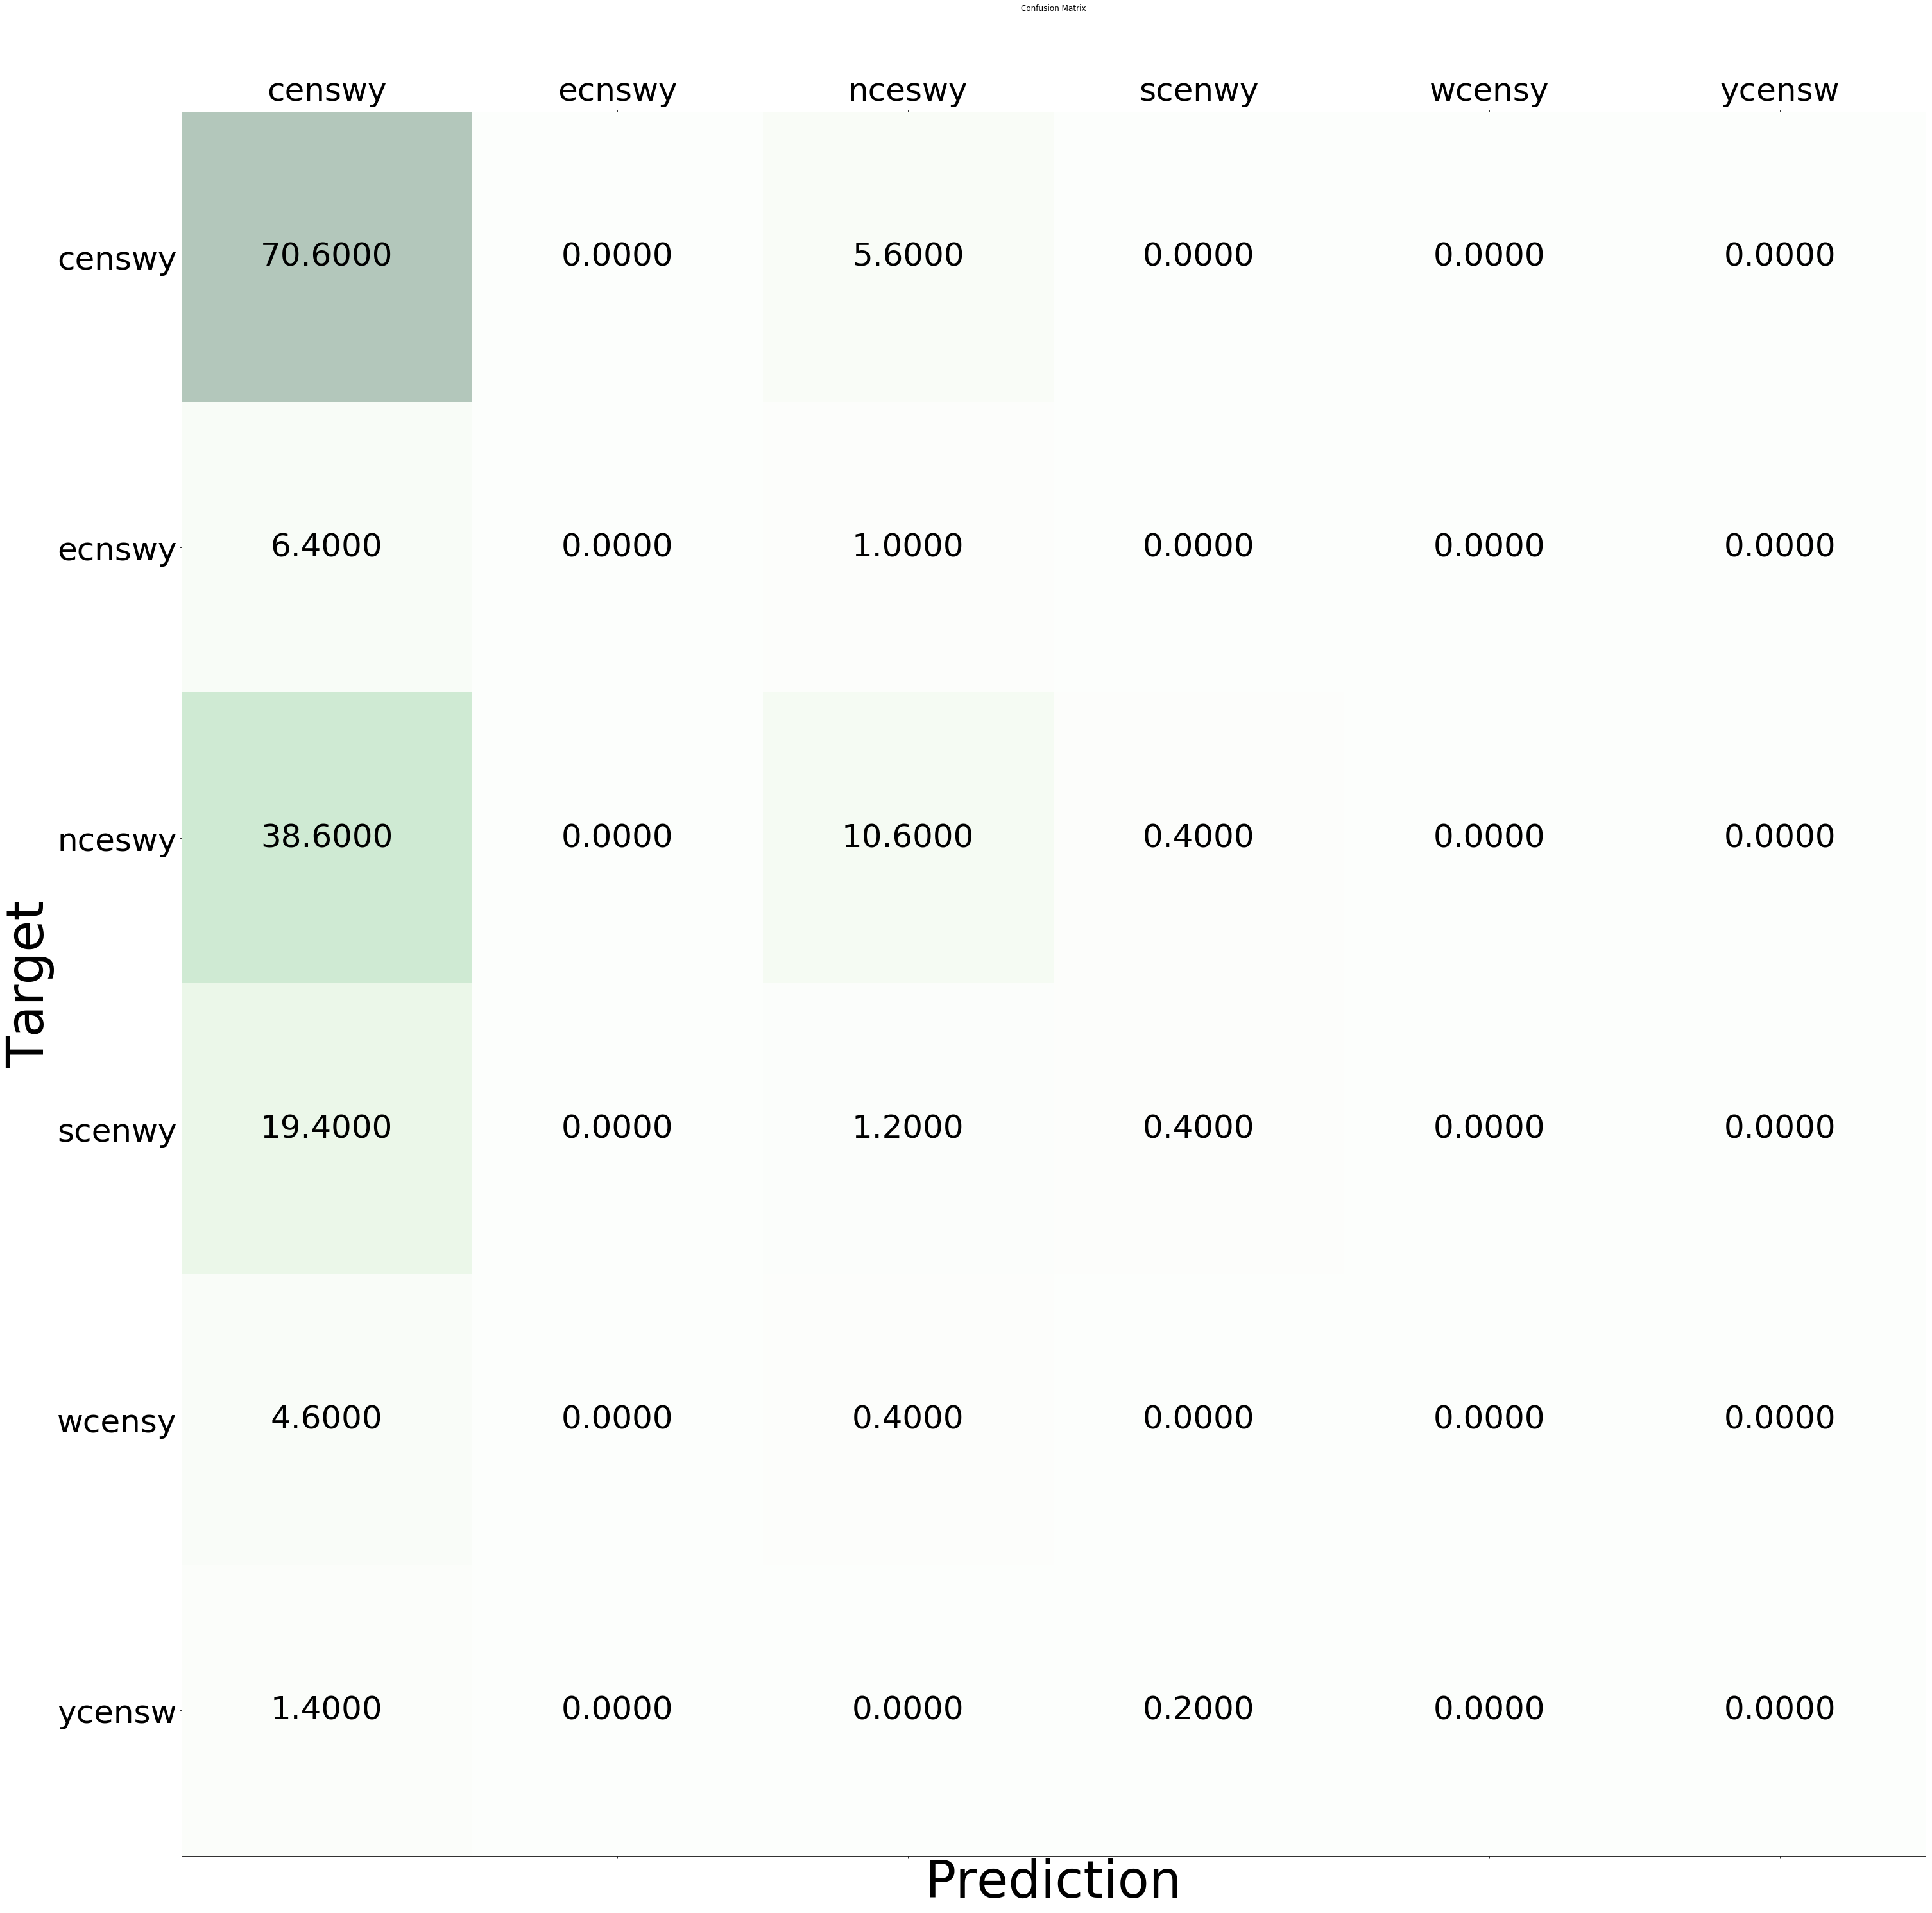

In [37]:
random_forest_KFold(10)